<a href="https://www.nvidia.com/dli"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# 使用 TensorFlow 进行文本生成

## 递归神经网络简介

### Data Preparation

在本节中，我们将创建的模型会根据句子的前一个单词预测句子中下一个单词，从而生成对语言的理解。

在先前的实验室中，我们已对网络应用于含有标注的图像数据集。我们将在这里介绍用于学习文本语料库的语言结构的神经网络。

我们将从一个小示例开始，使用小型英语语言子集以及包含两个句子的小语料库，该语料库将包含任何神经网络模型需要学习的语言结构。我们将从这里开始构建，可以表示更多真实世界的内容。

首先，我们的字典（点击下面的单元，并按住 Shift + Enter 键以执行代码）：

In [1]:
small_dict=['EOS','a','my','sleeps','on','dog','cat','the','bed','floor'] #'EOS' means end of sentence.

然后，我们可以创建小语料库以便网络学习语言。我们来一起根据字典中的单词创建几个句子。numpy 数组“X”中的第一个向量表示句子 ['my','cat','sleeps','on','my','bed', 'EOS']。将该数组作为模型，使用句子 ['a', 'dog', 'sleeps', 'on', 'the', 'floor', 'EOS'] 代替 ##FIXME## 向量。将鼠标指针悬停在 [此处](#hint "The second line should be X=np.array([[2,6,3,4,2,8,0],[1,5,3,4,7,9,0]]),dtype=np.int32)")可获取提示。

In [4]:
import numpy as np #numpy is "numerical python" and is used in deep learning mostly for its n-dimensional array
X=np.array([[2,6,3,4,2,8,0],[1,5,3,4,7,9,0]],dtype=np.int32) 
print([small_dict[ind] for ind in X[1,:]]) #Feel free to change 1 to 0 to see the other sentence.

['a', 'dog', 'sleeps', 'on', 'the', 'floor', 'EOS']


现在，我们有了数据，然后需要针对神经网络模型进行构建计算过程。单词是与图像完全不同类型的数据。一张 28X28 的灰度图像被视为一个 28X28 的矩阵，其中每个单元格都表示该像素的“灰度值”。一张 256X256 彩色的图像被视为一个 256X256X3 的[张量](#tensor "a vector, matrix, or any other *block* of n-dimensional data") ，其中每个单元格都包含每个像素的“红色度”、“绿色度”和“蓝色度”。

对图像进行分类时，我们使用 TensorFlow（或任何其他框架）来说明该输入张量如何流向概率向量。

另外，单词也必须先转换为张量，然后才能将它们用作输入。对于此示例，我们将使用“独热编码”，其中每个单词都将由一个包含一个“1”且其余全部为 0 的向量表示。这些向量将成为字典的长度，其中包含一个位于唯一位置的“1”，具体取决于每个单词。

![](images/one-hot.PNG)

为了便于理解，我们将运行 TensorFlow [会话](#sess "where computational graphs described in TensorFlow are run") ，将我们的输入数据转换为独热编码并对其进行可视化。通过 Tensorflow 的 embedding_lookup 和 unstack 函数，可以很容易地完成此操作。对于独热编码，我们可以向 embedding_lookup 传递一个 [单位矩阵](#idmat "A matrix with ones in the diagonal and zeros everywhere else")，其中包含字典和输入数据集的长度。此操作可以在训练会话过程中完成，但我们在此处将它分离出来，以便更好地对输入实现可视化。

为了提醒我们使用的英语语言子集有多小，请将 ##FIXME## 替换为字典的长度。将鼠标指针悬停在 [此处](#dict_length "Replace ##FIXME## in np.identity with len(small_dict).")可获取提示。

In [6]:
import tensorflow as tf
from tensorflow.python.framework import ops

tf.reset_default_graph()
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    


with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        result=tf.nn.embedding_lookup(np.identity(10), X).eval()  #单位矩阵取某一行作为独热编码
        example_input=sess.run([tf.unstack(result,X.shape[1],1)])
        coord.request_stop()
        coord.join(threads)
        sess.close()
print('one-hot encoded inputs')
print(result)
print('shape of the input')
print(result.shape)
print('reshaped input for training')
print(example_input)

[[2 6 3 4 2 8 0]
 [1 5 3 4 7 9 0]]
one-hot encoded inputs
[[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
shape of the input
(2, 7, 10)
reshaped input for training
[[array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]), array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]), ar

The dimensions we ended up with are (x, y, z) where:    
```x = The number of sentences in our corpus  
y = The number of words in each sentence  
z = The number of words in our corpus ```

我们有了自己的数据！

回想一下，神经网络一开始使用随机值填充。通过应用数据，网络“学会”了创建从输入到输出的准确映射。


### The Word Generation Workflow

我们的图像分类网络根据图像输入来输出标签预测。我们的语言处理网络将根据先前输入的单词来输出下一个单词。

例如，让我们选择一个句子，然后尝试自己完成该操作（请尽量不要阅读后面的内容）：

我们的句子以单词“My”开头

通过使用包含所有您知道的单词的字典以及您在生活中观察到的模式，什么单词可能会出现在单词“My”之后？

非常好，您已进行了猜测，然后会发现第二个词是“friend”。

您对这个句子有了进一步的了解，并且可以使用前“两个”单词猜测第三个单词。

接下来，您会了解到第三个单词是“went”，您会比较猜测的误差,然后再次猜测。与刚开始的时候相比，您是否对这个句子的结构有了更多的了解？如果这是您看到的第一个或第一千个句子，您可能还知道所有句子结构的更多信息。

这是神经网络学习语言的一种方式，此类型的网络称为**递归神经网络 (RNN)**。如果有足够的时间和足够大的数据集，它们可以学习所有类型的语言语法：“主语”如何与“动词”相关、标点符号通常会在何时出现等。它们通过减少所预测的下一个单词和语料库中实际的下一个单词之间的误差来进行学习。RNN 被构造为“记住”引发预测的单词。

通过使用只有一层的最简单的 RNN网络，看看从两个句子中我们能学到这 8 个单词间怎样的关系。

Start with 10 epochs by replacing the ##FIXME## below with the number 10. 

In [9]:
epochs=500
plot_loss=[]
num_hidden=24  #？？？
num_steps=X.shape[1]
dict_length=len(small_dict)
batch_size=2  #？
tf.reset_default_graph()

## Make Variables
variables_dict = {
    "weights1":tf.Variable(tf.truncated_normal([num_hidden,dict_length],stddev=1.0,dtype=tf.float32),name="weights1"),
    "biases1": tf.Variable(tf.truncated_normal([dict_length],stddev=1.0,dtype=tf.float32), name="biases1")}

# Create input data
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), X) #[batch,num_steps,dictionary_length][2,6,7]
y=np.zeros((batch_size,num_steps),dtype=np.int32)
y[:,:-1]=X[:,1:]  #写的好，往后移一位
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), y),num_steps,1) #[batch,num_steps,dictionary_length][2,6,7]

y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])

#Create our LSTM
cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)

outputs, last_states = tf.contrib.rnn.static_rnn(
    cell=cell,
    dtype=tf.float32,
    inputs=tf.unstack(tf.to_float(X_one_hot),num_steps,1))

output_reshape=tf.reshape(outputs, [batch_size*num_steps,num_hidden]) #[12==batch_size*num_steps,num_hidden==12]
pred=tf.matmul(output_reshape, variables_dict["weights1"]) +variables_dict["biases1"]
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    

plot_loss=[]

with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)        
        for i in range(epochs):
            loss,_,y_target,y_pred,output=sess.run([cost,optimizer,y_target_reshape,pred,outputs])
            plot_loss.append([loss])

            if i% 5 ==0:
                print("iteration: ",i," loss: ",loss)
                
        print(y_target)
        print(np.argmax(y_pred,1))          
        coord.request_stop()
        coord.join(threads)
        sess.close()  

('iteration: ', 0, ' loss: ', 2.3385096)
('iteration: ', 5, ' loss: ', 1.755022)
('iteration: ', 10, ' loss: ', 1.449616)
('iteration: ', 15, ' loss: ', 1.0782657)
('iteration: ', 20, ' loss: ', 0.70797634)
('iteration: ', 25, ' loss: ', 0.41246977)
('iteration: ', 30, ' loss: ', 0.2432205)
('iteration: ', 35, ' loss: ', 0.144933)
('iteration: ', 40, ' loss: ', 0.086883694)
('iteration: ', 45, ' loss: ', 0.05280648)
('iteration: ', 50, ' loss: ', 0.033164337)
('iteration: ', 55, ' loss: ', 0.022017434)
('iteration: ', 60, ' loss: ', 0.01565735)
('iteration: ', 65, ' loss: ', 0.011823485)
('iteration: ', 70, ' loss: ', 0.009352837)
('iteration: ', 75, ' loss: ', 0.007679077)
('iteration: ', 80, ' loss: ', 0.0065005156)
('iteration: ', 85, ' loss: ', 0.005637345)
('iteration: ', 90, ' loss: ', 0.004979857)
('iteration: ', 95, ' loss: ', 0.0044613923)
('iteration: ', 100, ' loss: ', 0.0040409495)
('iteration: ', 105, ' loss: ', 0.003692043)
('iteration: ', 110, ' loss: ', 0.003396743)
('i

RNN 已看到这 2 个句子 10 次。每次看到一个新单词时，都会尝试预测下一个单词。TensorFlow显示这些预测中的“损失”或误差约为 2.15。我们来看看使用样本句子会得出怎样结果。

In [11]:
#Lets look at one input data point at each step and its prediction
print("Input Sentence")
sn=0 #The sentence number
print([small_dict[ind] for ind in X[sn,:]])
print("Predicted Words")
print([small_dict[ind] for ind in np.argmax(y_pred[sn::2],1)])

Input Sentence
['my', 'cat', 'sleeps', 'on', 'my', 'bed', 'EOS']
Predicted Words
['cat', 'sleeps', 'on', 'my', 'bed', 'EOS', 'EOS']


To make sense of the output above, each "Predicted Word" was predicted to follow the corresponding word in the "Input Sentence". Eg. the first "Predicted Word" was predicted to follow the input word, "My", and the second predicted word was predicted to follow the two words, "My cat."

我们是否可以开始预测句子？至少能否预测出训练用的句子？通过将句子的第一个单词传递到预测变量，结果应该是我们的原始句子。发生了什么？

### Improving Performance  
#### Study More


尝试将上述代码块中的迭代次数增加到 300。这将如何影响神经网络预测原始句子的能力？

Note that increased training time still does help improve performance. However, remember that we're still working with a toy dataset. 

#### Deeper Networks

虽然能够完美地预测出小样本中的句子，但我们接下来将采用更复杂的示例。我们来看看现有的可以影响性能的一些手段：网络的深度和称为“dropout”的运算。

更深的模型能够表示更复杂的函数。为了在 TensorFlow 中构建一个更深的模型，我们可以在循环中创建自己的层。

我们来训练一个包含 2 个和 4 个层的 RNN。您需要设置什么参数来更改 RNN 中的层数？如需获取提示，请将鼠标指针悬停在[此处](#answer1 "num_layers=2 or num_layer=4. This is used in the 'for' loop where lstm_cells are created")。

Dropout 会要求您的模型在训练时“忘记”一些参数，从而提高模型的泛化能力。要查看在何处调整 dropout 值，请将鼠标指针悬停在[此处](#answer2 "dropout = ___, where 1.0 = none -remember everything and 0.0 = all -remember nothing. This is implemented here: lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,input_keep_prob=dropout,output_keep_prob=dropout)")。

对这两项进行试验，以确定是否可以提高性能。

In [15]:
#Now let's try multiple layers 
plot_loss2=[]
num_hidden=24
num_steps=X.shape[1]
dict_length=len(small_dict)
batch_size=2
num_layers=4
tf.reset_default_graph()

## Make Variables
variables_dict = {
    "weights1":tf.Variable(tf.truncated_normal([num_hidden,dict_length],stddev=1.0,dtype=tf.float32),name="weights1"),
    "biases1": tf.Variable(tf.truncated_normal([dict_length],stddev=1.0,dtype=tf.float32), name="biases1")}


# Create input data
#small_dict=['EOS','i','will','walk','the','dog','cat','run']
#X=np.array([[1,2,7,4,5,0],[1,2,3,4,6,0]],dtype=np.int32)  
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), X) 
y=np.zeros((batch_size,num_steps),dtype=np.int32)
y[:,:-1]=X[:,1:]
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), y),num_steps,1) 
y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])
dropout = 0.85


##################### Create a multilayer RNN ####################
layer_cell=[]
for _ in range(num_layers):
    lstm_cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)
    lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,
                                          input_keep_prob=dropout,
                                          output_keep_prob=dropout)
    layer_cell.append(lstm_cell)

cell = tf.contrib.rnn.MultiRNNCell(layer_cell, state_is_tuple=True)
outputs, last_states = tf.contrib.rnn.static_rnn(
    cell=cell,
    dtype=tf.float32,
    inputs=tf.unstack(tf.to_float(X_one_hot),num_steps,1))

output_reshape=tf.reshape(outputs, [batch_size*num_steps,num_hidden])
pred=tf.matmul(output_reshape, variables_dict["weights1"]) +variables_dict["biases1"]

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)


init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    


with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        for i in range(300):
            loss,_,y_target,y_pred,output=sess.run([cost,optimizer,y_target_reshape,pred,outputs])
            plot_loss2.append([loss])
            
            if i% 25 ==0:
                print("iteration: ",i," loss: ",loss)
                
        print(y_target)
        print(np.argmax(y_pred,1))         
        coord.request_stop()
        coord.join(threads)
        sess.close()    


('iteration: ', 0, ' loss: ', 2.5035634)
('iteration: ', 25, ' loss: ', 1.3529713)
('iteration: ', 50, ' loss: ', 0.852092)
('iteration: ', 75, ' loss: ', 0.6073251)
('iteration: ', 100, ' loss: ', 0.4819387)
('iteration: ', 125, ' loss: ', 0.29846668)
('iteration: ', 150, ' loss: ', 0.2039622)
('iteration: ', 175, ' loss: ', 0.12794822)
('iteration: ', 200, ' loss: ', 0.10972194)
('iteration: ', 225, ' loss: ', 0.13709183)
('iteration: ', 250, ' loss: ', 0.057982497)
('iteration: ', 275, ' loss: ', 0.07536502)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[6 5 3 3 4 4 2 7 8 9

#### 比较我们的单层 RNN 与多层 RNN 的损失。

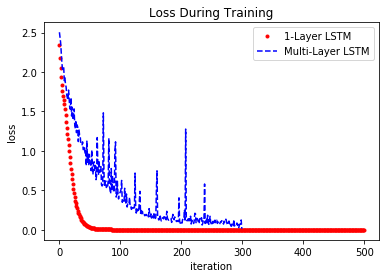

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(plot_loss,'r.')
plt.plot(plot_loss2,'b--')
plt.legend(["1-Layer LSTM","Multi-Layer LSTM"])
plt.ylabel("loss")
plt.xlabel("iteration")
plt.title("Loss During Training")
plt.show()

我们的模型也可以完成这两个句子，但同时对语言的其余部分一无所知。（这就像我们学习了一首歌的两行内容一样。）相反，如果改为努力构建对语言的一般理解，我们会严重地过拟合语料库。增加模型的复杂性（深度）可以学习更复杂的[语料库](#corpora "actually corpora")，但可能会导致过拟合。Dropout 是用于减少过拟合的一种方法。在我们努力学习完整类型的语言（即，说明）时，需要牢记这些策略。

### 使用 MSCOCO 说明训练 RNN
现在，我们将使用 [Microsoft Common Objects in Context](http://mscoco.org/) (MSCOCO)图像描述来训练 RNN ，理解这个图片的描述。以下单元显示了一种对数据进行读取和格式设置，并将其输入 TensorFlow 的方法。首先，我们将读取描述图片的文件，然后将文件中的文字内容删除标点并进行训练。由于时间限制，我们不会将完整数据集用于此训练。但是，可以很容易地更改代码内容，并使用更多的数据集内容或完整数据集进行训练。您是否有简单方法可完成此操作？

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import inspect
import time

from tensorflow.python.framework import dtypes
#import reader
import collections
import os
import re
import json

num_steps=20
## Read Training files
with open("/dli/data/mdt/mscoco/captions_train2014.json") as data_file:
         data=json.load(data_file)

TotalNumberofCaptions=len(data['annotations'])

sentences=[]

##Create a list of all of the sentences.
for i in range(TotalNumberofCaptions):
        sentences+=[re.sub('[^A-Za-z0-9]+',' ',data['annotations'][i]['caption']).lower()]  #正则表达式

TotalWordList=[]
for i in range(TotalNumberofCaptions):
        TotalWordList+=re.sub('[^A-Za-z0-9]+',' ',data['annotations'][i]['caption']).lower().split()

#Determine number of distinct words 
distinctwords=collections.Counter(TotalWordList)
#Order words 
count_pairs = sorted(distinctwords.items(), key=lambda x: (-x[1], x[0])) #ascending order

words, occurence = list(zip(*count_pairs))
DictionaryLength=occurence.index(4) #index for words that occur 4 times or less
words=['PAD','UNK','EOS']+list(words[:DictionaryLength])
word_to_id=dict(zip(words, range(len(words))))
#Tokenize Sentence
Tokenized=[]
for full_words in sentences:
        EmbeddedSentence=[word_to_id[word] for word in full_words.split() if word in word_to_id]+[word_to_id['EOS']]
        #Pad sentences that are shorter than the number of steps 
        if len(EmbeddedSentence)<num_steps:
            b=[word_to_id['PAD']]*num_steps
            b[:len(EmbeddedSentence)]=EmbeddedSentence
        if len(EmbeddedSentence)>num_steps:
            b=EmbeddedSentence[:num_steps]
        if len(b)==EmbeddedSentence:
            b=EmeddedSentence
        b=[word_to_id['UNK'] if x>=DictionaryLength else x for x in b] #turn all words used 4 times or less to 'UNK'
        #print(b)
        Tokenized+=[b]

我们可以针对这些描述进行“标记化”，或者将每个单词转换为一个数字（根据流行度按降序排序）。我们还有不同的句子长度，因此，为了创建标准的输入和输出张量，我们使用 0 填充短句子并截断了长句子。

In [18]:
############################################# Parameters #####################################################

num_hidden=256
num_steps=20
dict_length=len(words)
batch_size=4


## Create labels
Label=[]
for caption in Tokenized:
    Label+=[caption[1:]+[word_to_id['PAD']]]

NumberofCasestoEvaluate=20
TrainingInputs=Tokenized[:NumberofCasestoEvaluate]
LabelInputs=Label[:NumberofCasestoEvaluate]

#Print out some variables 
print(TrainingInputs[0])
print(LabelInputs[0])
print("Number of words in this dictionary", len(words))

[3, 142, 508, 9, 619, 415, 276, 57, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[142, 508, 9, 619, 415, 276, 57, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of words in this dictionary 8768


您可以看到两方面的内容：

1. [标签](#labels "labels are the outputs that we want our network to generate")是训练集中的下一个“token”（单词的标记）。
2. 字典更大。 

我们将分 4 批将数据输入网络，以便进一步充分利用并行处理和 GPU计算，降低计算时间。

In [22]:
#Create our input queue
def data_input_queue(TrainingInputs, LabelInputs, num_steps):
    train_input_queue = tf.train.slice_input_producer(                 #并行处理
                                    [TrainingInputs, LabelInputs],
                                    shuffle=True)

    ##Set our train data and label input shape for the queue
    TrainingInput=train_input_queue[0]
    LabelInput=train_input_queue[1]
    TrainingInput.set_shape([num_steps])
    LabelInput.set_shape([num_steps])
    min_after_dequeue=100000
    capacity = min_after_dequeue + 3 * batch_size 
    #input_x, target_y
    train_x, train_y = tf.train.batch([TrainingInput, LabelInput],           #与上面一起用
                                                 batch_size=batch_size ,
                                                 capacity=capacity,
                                                 num_threads=4)
    return train_x, train_y

现在，您已准备好使用 MSCOCO 说明训练 RNN。可以使用任意层数进行试验，并再次执行 dropout。

In [23]:
tf.reset_default_graph()
num_layers=1
dropout = 1.0

loss_mscoco=[]
#######################################################################################################
TrainingInputs=Tokenized[:NumberofCasestoEvaluate]
LabelInputs=Label[:NumberofCasestoEvaluate]


variables_dict = {
    "weights_mscoco":tf.Variable(tf.truncated_normal([num_hidden,dict_length],
                                                     stddev=1.0,dtype=tf.float32),name="weights_mscoco"),
    "biases_mscoco": tf.Variable(tf.truncated_normal([dict_length],
                                                     stddev=1.0,dtype=tf.float32), name="biases_mscoco")}


# Create input data
train_x, train_y =data_input_queue(TrainingInputs, LabelInputs, num_steps)
mscoco_dict=words
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), train_x) #[batch,num_steps,dictionary_length]
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), train_y),num_steps,1)#[batch,num_steps,dictionary_length]
y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])

input_keep_prob=dropout
output_keep_prob=dropout

#Create a multilayer RNN

layer_cell=[]
for _ in range(num_layers):
    lstm_cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)
    ############# add dropout #########################
    lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,
                                          input_keep_prob=dropout,
                                          output_keep_prob=dropout)
    layer_cell.append(lstm_cell)

cell = tf.contrib.rnn.MultiRNNCell(layer_cell, state_is_tuple=True)
outputs, last_states = tf.contrib.rnn.static_rnn(
    cell=lstm_cell,
    dtype=tf.float32,
    inputs=tf.unstack(tf.to_float(X_one_hot),num_steps,1))

output_reshape=tf.reshape(outputs, [batch_size*num_steps,num_hidden])
pred=tf.matmul(output_reshape, variables_dict["weights_mscoco"]) +variables_dict["biases_mscoco"]
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost,aggregation_method = tf.AggregationMethod.EXPERIMENTAL_TREE)


init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    


with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        for i in range(1500):
            x_input,y_input=sess.run([train_x, train_y])
            loss,_,y_target,x_input,y_input,y_pred=sess.run([cost,optimizer,y_target_reshape,train_x, train_y,pred])
            loss_mscoco.append([loss])
            if i% 100==0:
                print("iteration: ",i, "loss: ",loss)  
        print("Done Training")
        coord.request_stop()
        coord.join(threads)
        sess.close()    

iteration:  0 loss:  8.478596
iteration:  100 loss:  0.110077426
iteration:  200 loss:  0.089920625
iteration:  300 loss:  0.05734334
iteration:  400 loss:  0.111818396
iteration:  500 loss:  0.09395734
iteration:  600 loss:  0.102980815
iteration:  700 loss:  0.08803368
iteration:  800 loss:  0.10325841
iteration:  900 loss:  0.10161339
iteration:  1000 loss:  0.06951494
iteration:  1100 loss:  0.1013256
iteration:  1200 loss:  0.10544834
iteration:  1300 loss:  0.1082193
iteration:  1400 loss:  0.11626966
Done Training


In [21]:
#Lets look at one input data point and its prediction
print("Input Sentence")
batch_element=2
print([words[ind] for ind in x_input[batch_element,:]])
print("Target")
print([words[ind] for ind in y_input[batch_element,:]])
print("Predicted words")
print([words[ind] for ind in np.argmax(y_pred[batch_element::batch_size],1)])

Input Sentence
[u'a', u'graffiti', u'ed', u'stop', u'sign', u'across', u'the', u'street', u'from', u'a', u'red', u'car', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Target
[u'graffiti', u'ed', u'stop', u'sign', u'across', u'the', u'street', u'from', u'a', u'red', u'car', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Predicted words
[u'panoramic', u'ed', u'stop', u'sign', u'across', u'the', u'street', u'from', u'a', u'red', u'car', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


我们该怎么做？我们已学习使用 RNN 根据前一个单词预测下一个单词， 及RNN 对语言的理解。
通过部署此模型，我们可以解决什么类型的问题？
如果掌握了能够很好地完成这项工作的技能，我们可以做一些有意思的事情，比如模仿某人的书写风格、根据过去的表现生成股票市场报价预测或者在文本消息中提供后续单词建议。
目前为止，我们受限于[真值](#gt "actual next word at every timestep") 是在整个网络中传递这一事实。如果我们生成不止一个单词，表现将会很糟糕。

要让我们的网络生成完整的句子，一种方法是提供一些上下文。在下一节中，我们将以图像的形式为网络提供默想，也就是要书写的内容。

## 参考资料
[1] Imanol Schlab. TensorFlow Input Pipeline Example. http://ischlag.github.io/

[2] Denny Britz. Practical Examples for RNNs in TensorFlow https://github.com/dennybritz/tf-rnn

[3]Lin, Tsung-Yi, et al. "Microsoft coco: Common objects in context." European Conference on Computer Vision. Springer International Publishing, 2014.